In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Networkx

In [2]:
# initialize a graph
G = nx.Graph()

print(G.nodes())
print(G.edges())


[]
[]


In [3]:
# populate the graph
G.add_node(1)
G.add_node(2)

print(G.nodes())
print(G.edges())

[1, 2]
[]


In [4]:
G.add_edge(1, 2)
G.add_edge(2, 3)

print(G.nodes())
print(G.edges())

[1, 2, 3]
[(1, 2), (2, 3)]


In [5]:
# get node degree
G.degree()

DegreeView({1: 1, 2: 2, 3: 1})

In [6]:
# create network from ER model
G = nx.erdos_renyi_graph(10000, 0.0005)

print(len(G.nodes()))
print(len(G.edges()))

10000
25078


In [8]:
10000 * 10000 * 0.0005 / 2

25000.0

Text(0.5, 1.0, 'Degree Distribution ER Graph')

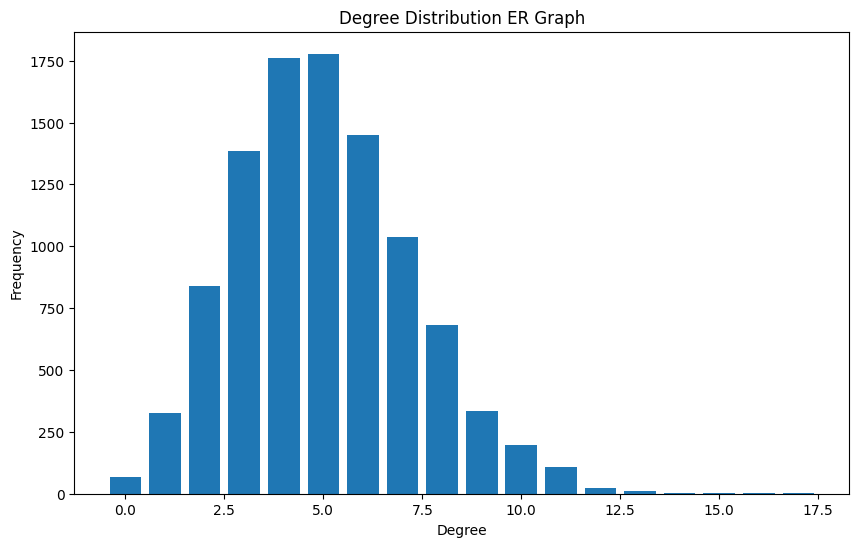

In [9]:
from collections import Counter

# Get the degree of each node
degrees = dict(G.degree())

# Count the occurrences of each degree
degree_counts = Counter(degrees.values())

# Sort the degree counts by degree
sorted_degree_counts = sorted(degree_counts.items())

# Extract the degrees and their respective counts
degrees, counts = zip(*sorted_degree_counts)

# Plot the degree distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(degrees, counts)
ax.set_xlabel('Degree')
ax.set_ylabel('Frequency')
ax.set_title('Degree Distribution ER Graph')

In [10]:
# create network from BA model
G = nx.barabasi_albert_graph(10000, 3)

print(len(G.nodes()))
print(len(G.edges()))

10000
29991


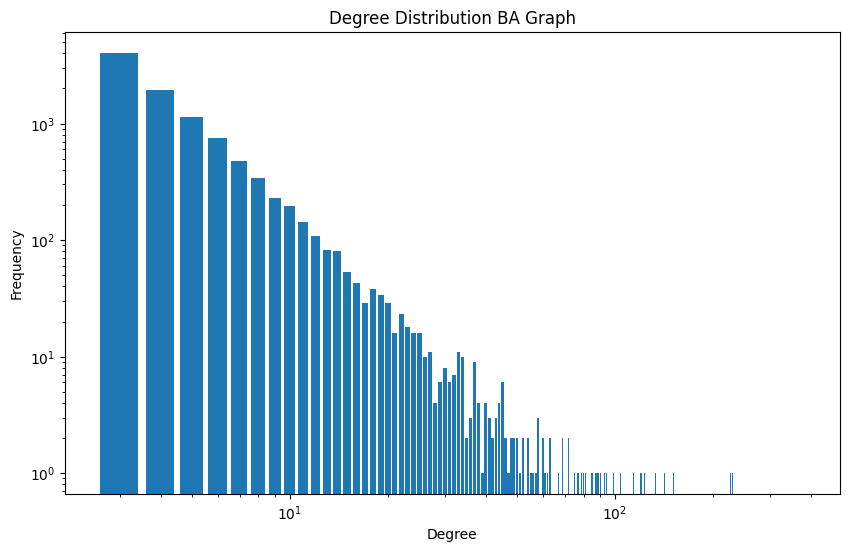

In [11]:
from collections import Counter

# Get the degree of each node
degrees = dict(G.degree())

# Count the occurrences of each degree
degree_counts = Counter(degrees.values())

# Sort the degree counts by degree
sorted_degree_counts = sorted(degree_counts.items())

# Extract the degrees and their respective counts
degrees, counts = zip(*sorted_degree_counts)

# Plot the degree distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(degrees, counts)
ax.set_xlabel('Degree')
ax.set_ylabel('Frequency')
ax.set_title('Degree Distribution BA Graph')

ax.set_xscale('log')
ax.set_yscale('log')


# SI Model on Network

In [12]:
def set_seeds(N, p):
    """
    Function to set the infected seeds of the simulation.

    Parameters:
        N (int): Number of nodes
        p (float): Probability of infection

    Returns:
        status (array): Array of the status of each node
    """
    status = [1 if np.random.uniform(0, 1) < p else 0 for i in range(N)]
    return np.array(status)


def SI_network(G, beta, T_final, p, dt=1):    
    """
    Function to simulate the SI model on network.

    Parameters:
        G (nx.Graph): Networkx graph
        beta (float): Infection rate
        T_final (float): Final time of the simulation
        p (float): Fraction of infected at t=0
        dt (float): Time step

    Returns:
       status (array): Array of the status of each node
       steps (array): Array of the time steps
       incidence (array): Array of the number of new infected at each time step
       S (array): Array of the number of susceptible at each time step
       I (array): Array of the number of infected at each time step
    """
    
    # simulation steps
    steps = np.arange(0, T_final + dt, dt) 

    # initalize the status of the nodes
    status = set_seeds(len(G.nodes()), p)

    # here we will store the number of infected at each time step
    incidence = []

    # here we will store the number of nodes in each compartment
    S, I = [np.sum(status == 0)], [np.sum(status == 1)]

    # iterate over time steps 
    for t in steps:
        
        # here we will store which nodes will be infected next
        temp = set()  
        # here we will store the number of infected at this time step
        inf_step = 0

        # iterate over all the nodes
        for i in G.nodes():
            # if the node is infected
            if status[i] == 1:
                # we go through her neighbors an we try to infect each S
                for j in G.neighbors(i):
                    if status[j]==0 and np.random.uniform(0, 1) < beta * dt:
                        temp.add(j) # this node will be infected next
                        inf_step += 1
                                    
        # update the status
        for i in temp:
            status[i] = 1

        # store the number of infected at this time step
        incidence.append(inf_step)

        # store the number of nodes in each compartment
        S.append(np.sum(status == 0))
        I.append(np.sum(status == 1))


    return status, steps, incidence, S, I


In [21]:
# number of nodes
N = 10000

# create a network and simulate the SI model
G_BA = nx.barabasi_albert_graph(n=N, m=3)
status_BA, steps_BA, incidence_BA, S_BA, I_BA = SI_network(G_BA, beta=0.05, T_final=50, p=0.01, dt=1)

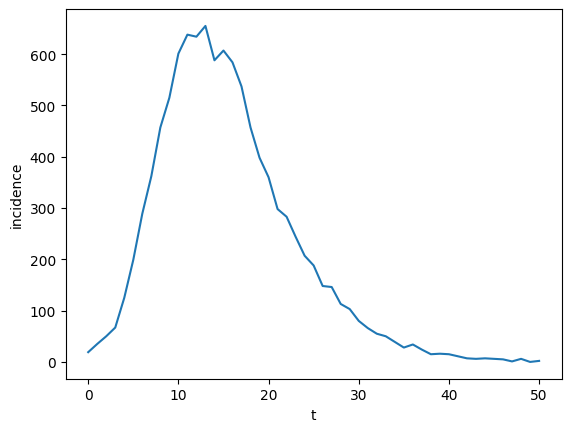

In [22]:
plt.plot(incidence_BA)
plt.xlabel('t')
plt.ylabel('incidence')
plt.show()

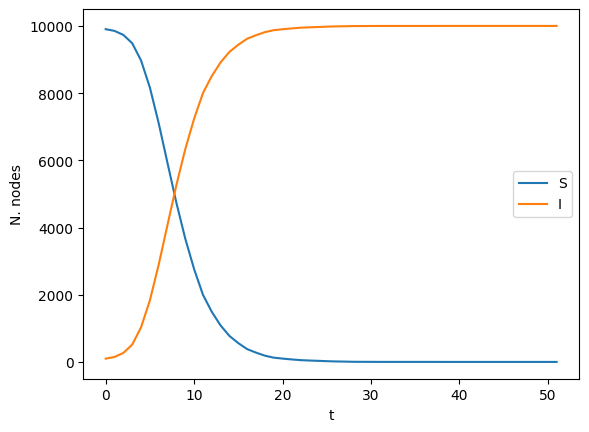

In [15]:
plt.plot(S_BA, label='S')
plt.plot(I_BA, label="I")

plt.xlabel('t')
plt.ylabel('N. nodes')
plt.legend()
plt.show()

Now we consider other network models

In [23]:
# average degree of the network
av_deg_BA = 2 * G_BA.number_of_edges() / G_BA.number_of_nodes()

# create ER network with the same average degree and number of nodes (<k>=pN --> p=<k>/N)
G_ER = nx.erdos_renyi_graph(N, av_deg_BA / N)

# check
av_deg_ER = 2 * G_ER.number_of_edges() / G_ER.number_of_nodes()
print("ER <k>:", av_deg_ER)
print("BA <k>:", av_deg_BA)


ER <k>: 6.0042
BA <k>: 5.9982


In [24]:
# simulate on ER network
status_ER, steps_ER, incidence_ER, S_ER, I_ER = SI_network(G_ER, beta=0.05, T_final=50, p=0.01, dt=1)

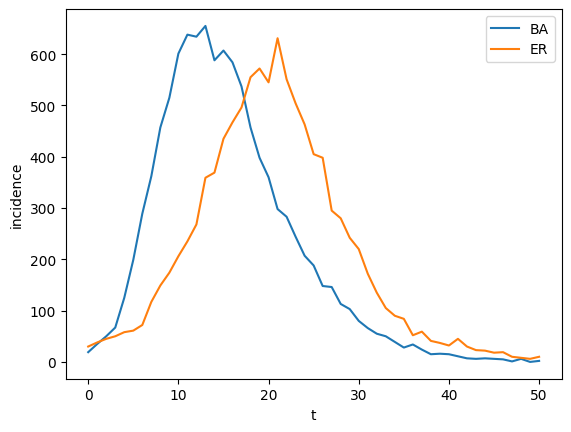

In [25]:
plt.plot(incidence_BA, label="BA")
plt.plot(incidence_ER, label="ER")

plt.xlabel('t')
plt.ylabel('incidence')
plt.legend()
plt.show()

In [19]:
# simulate on Watts-Strogatz network (p=0)
G_WS_p0 = nx.watts_strogatz_graph(N, int(av_deg_BA), 0)
status_WS_p0, steps_WS_p0, incidence_WS_p0, S_WS_p0, I_WS_p0 = SI_network(G_WS_p0, beta=0.1, T_final=50, p=0.01, dt=1)

# simulate on Watts-Strogatz network (p=0.1)
G_WS_p01 = nx.watts_strogatz_graph(N, int(av_deg_BA), 0.1)
status_WS_p01, steps_WS_p01, incidence_WS_p01, S_WS_p01, I_WS_p01 = SI_network(G_WS_p01, beta=0.1, T_final=50, p=0.01, dt=1)

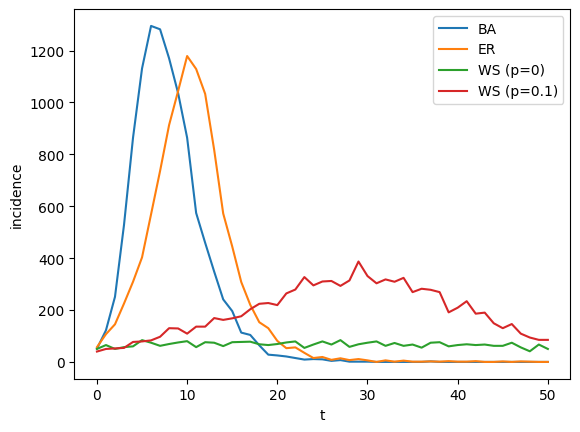

In [20]:
plt.plot(incidence_BA, label="BA")
plt.plot(incidence_ER, label="ER")
plt.plot(incidence_WS_p0, label="WS (p=0)")
plt.plot(incidence_WS_p01, label="WS (p=0.1)")
plt.xlabel('t')
plt.ylabel('incidence')
plt.legend()
plt.show()

# SIS Model on Network

In [26]:
def SIS_network(G, beta, mu, T_final, p, dt=1.):    
    """
    Function to simulate the SIS model on network.

    Parameters:
        G (nx.Graph): Networkx graph
        beta (float): Infection rate
        mu (float): Recovery rate
        T_final (float): Final time of the simulation
        p (float): Fraction of infected at t=0
        dt (float): Time step

    Returns:
       status (array): Array of the status of each node
       steps (array): Array of the time steps
       incidence (array): Array of the number of new infected at each time step
       S (array): Array of the number of susceptible at each time step
       I (array): Array of the number of infected at each time step
    """
    
    # simulation steps
    steps = np.arange(0, T_final + dt, dt) 

    # initalize the status of the nodes
    status = set_seeds(len(G.nodes()), p)

    # here we will store the number of infected at each time step
    incidence = []

    # here we will store the number of nodes in each compartment
    S, I = [np.sum(status == 0)], [np.sum(status == 1)]

    # iterate over time steps 
    for t in steps:

        # here we will store which nodes will be infected next
        temp_inf = set()  
        # here we will store which nodes will be recovered next
        temp_rec = set()
        # here we will store the number of new infected at this time step
        inf_step = 0

        # iterate over all the nodes
        for i in G.nodes():
            # if the node is infected
            if status[i] == 1:
                # we go through her neighbors an we try to infect each S
                for j in G.neighbors(i):
                    if status[j]==0 and np.random.uniform(0, 1) < beta * dt:
                        temp_inf.add(j) # this node will be infected next
                        inf_step += 1

                # recovery process
                if np.random.uniform(0, 1) < mu * dt:
                    temp_rec.add(i)
                                    
        # update the status
        for i in temp_inf:
            status[i] = 1  
        for i in temp_rec:
            status[i] = 0

        # store the number of infected at this time step
        incidence.append(inf_step)

        # store the number of nodes in each compartment
        S.append(len(G.nodes()) - np.sum(status))
        I.append(np.sum(status))

    return status, steps, incidence, S, I

In [27]:
# number of nodes
N = 10000

# create a network and simulate the SI model
G_BA = nx.barabasi_albert_graph(n=N, m=3)
status_BA, steps_BA, incidence_BA, S_BA, I_BA = SIS_network(G_BA, beta=0.1, mu=0.2, T_final=50, p=0.01, dt=1)

G_ER = nx.erdos_renyi_graph(N, 2 * G_BA.number_of_edges() / G_BA.number_of_nodes() / N)
status_ER, steps_ER, incidence_ER, S_ER, I_ER = SIS_network(G_ER, beta=0.1, mu=0.2, T_final=50, p=0.01, dt=1)

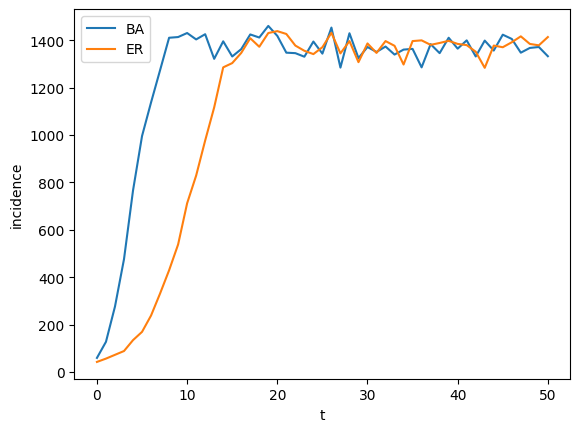

In [28]:
plt.plot(incidence_BA, label="BA")
plt.plot(incidence_ER, label="ER")

plt.xlabel('t')
plt.ylabel('incidence')
plt.legend()
plt.show()

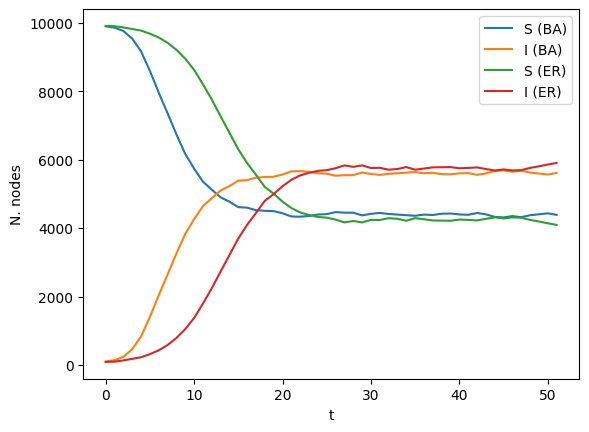

In [29]:
plt.plot(S_BA, label='S (BA)')
plt.plot(I_BA, label="I (BA)")

plt.plot(S_ER, label='S (ER)')
plt.plot(I_ER, label="I (ER)")

plt.xlabel('t')
plt.ylabel('N. nodes')
plt.legend()
plt.show()

# Threshold Behavior

We test the threshold behavior of the SIS model on ER and BA networks.

In [30]:
def compute_threshold(G):
    # get degrees
    degrees = np.array(list((dict(G.degree()).values())))
    k_mean = np.mean(degrees)
    k_mean2 = np.mean(degrees**2)

    return k_mean / k_mean2

print("Threshold ER", compute_threshold(G_ER))
print("Threshold BA", compute_threshold(G_BA))

# BA with higher number of nodes
G = nx.barabasi_albert_graph(n=10**6, m=3)
print("Threshold BA (1M nodes)", compute_threshold(G))

Threshold ER 0.14153751554704644
Threshold BA 0.05584510622133588
Threshold BA (1M nodes) 0.03620791836721689


We start with the ER network.

In [31]:
th_ER = compute_threshold(G_ER)
mu = 0.2

# compute beta threshold and beta values around the threshold
beta_th_ER = th_ER * mu
betas = np.concatenate((np.linspace(0.5 * beta_th_ER, beta_th_ER * 0.9, 5),
                        np.linspace(beta_th_ER * 0.9, beta_th_ER * 1.1, 10)[1:],
                        np.linspace(beta_th_ER * 1.1, beta_th_ER * 2, 5)[1:]))

I_inf_ER = []
for beta in betas:
    status_ER, steps_ER, incidence_ER, S_ER, I_ER = SIS_network(G_ER, beta=beta, mu=0.2, T_final=100, p=0.01, dt=1)
    I_inf_ER.append(I_ER[-1])

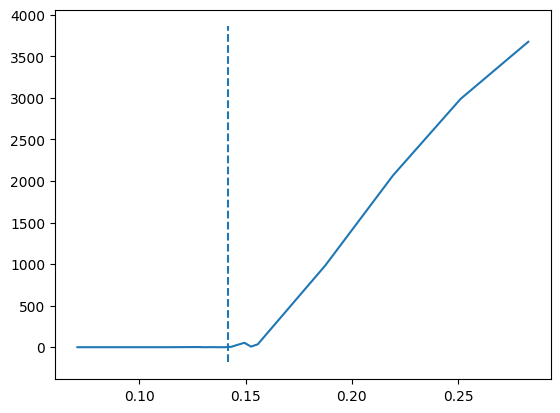

In [36]:
fig, ax = plt.subplots()
ax.plot(np.array(betas) / mu, I_inf_ER)

y1, y2 = ax.get_ylim()
ax.vlines(np.array(beta_th_ER) / mu, y1, y2, linestyles='dashed')

Then we test the BA network.

In [32]:
mu = 0.2

I_inf_BA = []
for beta in betas:
    status_BA, steps_BA, incidence_BA, S_BA, I_BA = SIS_network(G_BA, beta=beta, mu=0.2, T_final=100, p=0.01, dt=1)
    I_inf_BA.append(I_BA[-1])

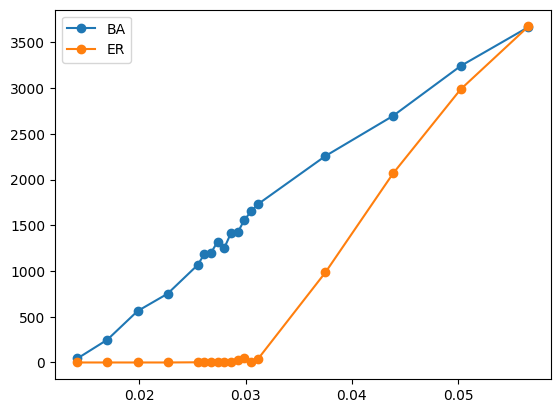

In [35]:
fig, ax = plt.subplots()
ax.plot(betas, I_inf_BA, label="BA", marker="o")
ax.plot(betas, I_inf_ER, label="ER", marker="o")
plt.legend()

# Immunization on Networks

We introduce a new compartment $V$ that represents the immunized nodes. We assume that the immunized nodes cannot be infected. 

We define three different strategies to immunize the nodes:
- random vaccination
- vaccination according to degree
- vaccination leveraging network topology (friendship paradox) 

In [37]:
def random_vaccination(status, p, G):
    """
    Function to randomly vaccinate nodes.

    Parameters:
        status (array): Array of the status of each node
        p (float): Fraction to immunize 
        G (nx.Graph): networkx graph

    Returns:
       status (array): Array of the status of each node
    """

    # get number of nodes to immunize
    n_vax = int(p * len(status))
    if n_vax == 0: 
        return status
    
    # get the indices of the nodes to immunize
    idx_vax = np.random.choice(np.arange(len(status)), n_vax, replace=False)

    # immunize the nodes
    for i in idx_vax:
        status[i] = 2

    return status


def degree_vaccination(status, p, G):
    """
    Function to vaccinate nodes according to their degree.

    Parameters:
        status (array): Array of the status of each node
        p (float): Fraction to immunize 
        G (nx.Graph): networkx graph

    Returns:
       status (array): Array of the status of each node
    """

    # get number of nodes to immunize
    n_vax = int(p * len(status))
    if n_vax == 0: 
        return status

    # get the indices of the nodes to immunize (n_vax highest degrees)
    degrees = np.array(list((dict(G.degree()).values())))
    idx_vax = np.argsort(degrees)[-n_vax:]

    # immunize the nodes
    for i in idx_vax:
        status[i] = 2

    return status


def friendship_vaccination(status, p, G):
    """
    Function to vaccinate nodes according to friendship paradox.

    Parameters:
        status (array): Array of the status of each node
        p (float): Fraction to immunize 
        G (nx.Graph): networkx graph

    Returns:
       status (array): Array of the status of each node
    """

    # get number of nodes to immunize
    n_vax = int(p * len(status))
    if n_vax == 0: 
        return status
    
    # select the probes
    idx_probes = np.random.choice(np.arange(len(status)), n_vax, replace=False)

    for probe in idx_probes:
        # select a random neighbor of the probe
        if len(list(G.neighbors(probe))) > 0:
            idx_vax = np.random.choice(list(G.neighbors(probe)), 1, replace=False)[0]
            status[idx_vax] = 2

    return status

We slightly modify the `SIS_network` function to include the vaccination strategy:

In [38]:
def SIS_network_vax(G, beta, mu, T_final, p, p_vax=0.0, vax_strategy=random_vaccination, dt=1.):    
    """
    Function to simulate the SIS model on network.

    Parameters:
        G (nx.Graph): Networkx graph
        beta (float): Infection rate
        mu (float): Recovery rate
        T_final (float): Final time of the simulation
        p (float): Fraction of infected at t=0
        p_vax (float): Fraction of immunized at t=0
        vax_strategy (function): Function to vaccinate nodes
        dt (float): Time step

    Returns:
       status (array): Array of the status of each node
       steps (array): Array of the time steps
       incidence (array): Array of the number of new infected at each time step
       S (array): Array of the number of susceptible at each time step
       I (array): Array of the number of infected at each time step
       V (array): Array of the number of vaccinates at each time step
    """
    
    # simulation steps
    steps = np.arange(0, T_final + dt, dt) 

    # initalize the status of the nodes
    status = set_seeds(len(G.nodes()), p)

    # vaccinate 
    status = vax_strategy(status, p_vax, G)

    # here we will store the number of infected at each time step
    incidence = []

    # here we will store the number of nodes in each compartment
    S, I, V = [np.sum(status == 0)], [np.sum(status == 1)], [np.sum(status == 2)]

    # iterate over time steps 
    for t in steps:

        # here we will store which nodes will be infected next
        temp_inf = set()  
        # here we will store which nodes will be recovered next
        temp_rec = set()
        # here we will store the number of new infected at this time step
        inf_step = 0

        # iterate over all the nodes
        for i in G.nodes():
            # if the node is infected
            if status[i] == 1:
                # we go through her neighbors an we try to infect each S
                for j in G.neighbors(i):
                    if status[j]==0 and np.random.uniform(0, 1) < beta * dt:
                        temp_inf.add(j) # this node will be infected next
                        inf_step += 1

                # recovery process
                if np.random.uniform(0, 1) < mu * dt:
                    temp_rec.add(i)
                                    
        # update the status
        for i in temp_inf:
            status[i] = 1  
        for i in temp_rec:
            status[i] = 0

        # store the number of infected at this time step
        incidence.append(inf_step)

        # store the number of nodes in each compartment
        S.append(np.sum(status == 0))
        I.append(np.sum(status == 1))
        V.append(np.sum(status == 2))

    return status, steps, incidence, S, I, V

We test the different vaccination strategies on the BA network:

In [39]:
# create a network and simulate the SI model
G_BA = nx.barabasi_albert_graph(n=N, m=3)

p_vax = np.linspace(0, 0.5, 10)
I_inf_rnd, I_inf_degree, I_inf_friendship = [], [], []

for p in p_vax:

    # random vaccination
    status_BA, steps_BA, incidence_BA, S_BA, I_BA, V_BA = SIS_network_vax(G_BA, beta=0.1, mu=0.2, T_final=50, p=0.01, p_vax=p, vax_strategy=random_vaccination, dt=1)
    I_inf_rnd.append(I_BA[-1])

    # degree targeted vaccination
    status_BA, steps_BA, incidence_BA, S_BA, I_BA, V_BA = SIS_network_vax(G_BA, beta=0.1, mu=0.2, T_final=50, p=0.01, p_vax=p, vax_strategy=degree_vaccination, dt=1)
    I_inf_degree.append(I_BA[-1])

    # friendship paradox vaccination
    status_BA, steps_BA, incidence_BA, S_BA, I_BA, V_BA = SIS_network_vax(G_BA, beta=0.1, mu=0.2, T_final=50, p=0.01, p_vax=p, vax_strategy=friendship_vaccination, dt=1)
    I_inf_friendship.append(I_BA[-1])

Text(0.5, 1.0, 'Immunization on Barabasi-Albert network')

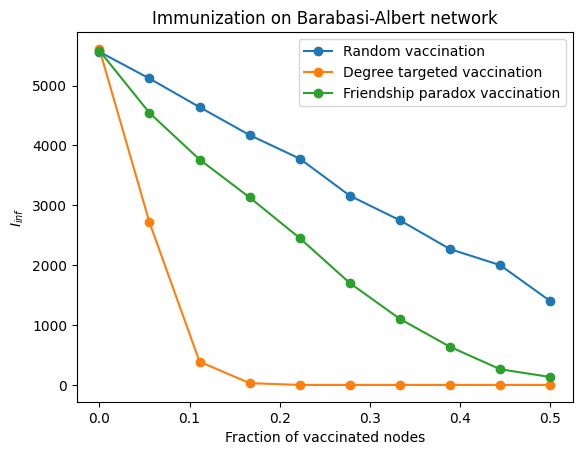

In [40]:
plt.plot(p_vax, I_inf_rnd, label="Random vaccination", marker="o")
plt.plot(p_vax, I_inf_degree, label="Degree targeted vaccination", marker="o")
plt.plot(p_vax, I_inf_friendship, label="Friendship paradox vaccination", marker="o")

plt.legend()
plt.ylabel("$I_{inf}$")
plt.xlabel("Fraction of vaccinated nodes")
plt.title("Immunization on Barabasi-Albert network")


We test the different vaccination strategies on the ER network:

In [41]:
# create a network and simulate the SI model
G_ER = nx.erdos_renyi_graph(N, 2 * G_BA.number_of_edges() / G_BA.number_of_nodes() / N)

p_vax = np.linspace(0, 0.5, 10)
I_inf_rnd, I_inf_degree, I_inf_friendship = [], [], []

for p in p_vax:

    # random vaccination
    status_ER, steps_ER, incidence_ER, S_ER, I_ER, V_ER = SIS_network_vax(G_ER, beta=0.1, mu=0.2, T_final=50, p=0.01, p_vax=p, vax_strategy=random_vaccination, dt=1)
    I_inf_rnd.append(I_ER[-1])

    # degree targeted vaccination
    status_ER, steps_ER, incidence_ER, S_ER, I_ER, V_ER = SIS_network_vax(G_ER, beta=0.1, mu=0.2, T_final=50, p=0.01, p_vax=p, vax_strategy=degree_vaccination, dt=1)
    I_inf_degree.append(I_ER[-1])

    # friendship paradox vaccination
    status_ER, steps_ER, incidence_ER, S_ER, I_ER, V_ER = SIS_network_vax(G_ER, beta=0.1, mu=0.2, T_final=50, p=0.01, p_vax=p, vax_strategy=friendship_vaccination, dt=1)
    I_inf_friendship.append(I_ER[-1])

Text(0.5, 1.0, 'Immunization on Erdos-Renyi network')

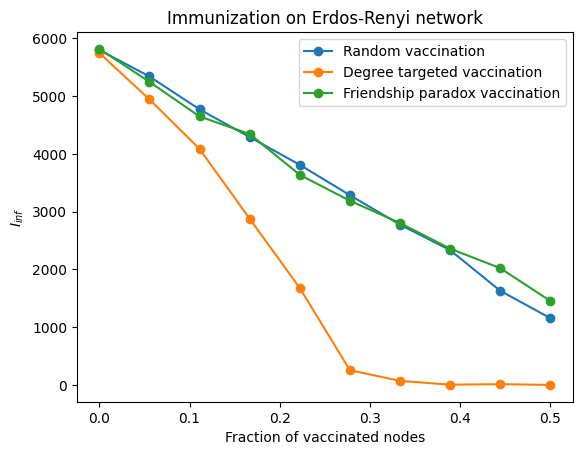

In [42]:
plt.plot(p_vax, I_inf_rnd, label="Random vaccination", marker="o")
plt.plot(p_vax, I_inf_degree, label="Degree targeted vaccination", marker="o")
plt.plot(p_vax, I_inf_friendship, label="Friendship paradox vaccination", marker="o")

plt.legend()
plt.ylabel("$I_{inf}$")
plt.xlabel("Fraction of vaccinated nodes")
plt.title("Immunization on Erdos-Renyi network")


# Epidemics on Networks (Python package)
https://github.com/springer-math/Mathematics-of-Epidemics-on-Networks



In [43]:
#pip install EoN

In [44]:
import EoN

Text(0.5, 1.0, 'SIS EoN')

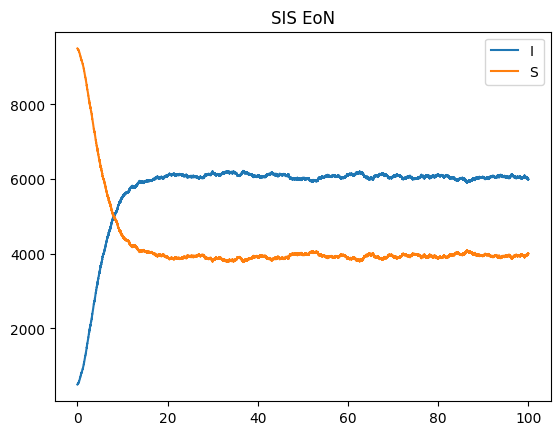

In [45]:
G_BA = nx.barabasi_albert_graph(n=N, m=3)

# EoN implementation of SIS model
t, S, I = EoN.fast_SIS(G_BA, 0.1, 0.2, rho=0.05)
plt.plot(t, I, label="I")
plt.plot(t, S, label="S")
plt.legend()
plt.title("SIS EoN")

Text(0.5, 1.0, 'SIR EoN')

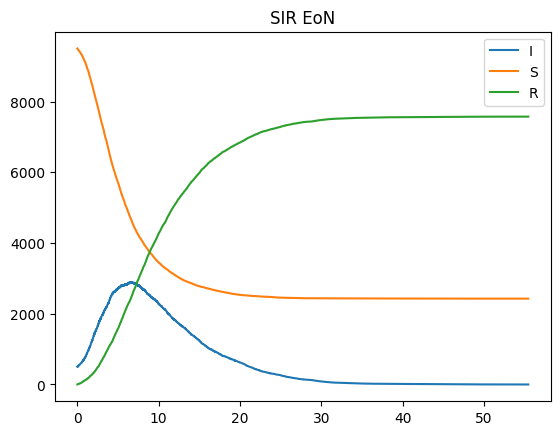

In [46]:
# EoN implementation of SIR model
t, S, I, R = EoN.fast_SIR(G_BA, 0.1, 0.2, rho=0.05)
plt.plot(t, I, label="I")
plt.plot(t, S, label="S")
plt.plot(t, R, label="R")

plt.legend()
plt.title("SIR EoN")